# Movie Rating Prediction Model
This notebook implements a predictive model to estimate movie ratings based on various attributes from the IMDb Movies India dataset.

In [77]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
import traceback

# Basic setup
warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)

# Visualization settings
plt.style.use('default')  # Use default style
sns.set_style("whitegrid")  # Set seaborn style separately
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Remove the setup_visualization_style function as it's no longer needed

## Load and Explore Dataset
Loading the IMDb Movies India dataset and performing initial exploratory data analysis. We'll check the data types, missing values, and basic statistics of our dataset.

Successfully loaded the file using latin1 encoding

Dataset shape: (15509, 10)

Missing values:
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


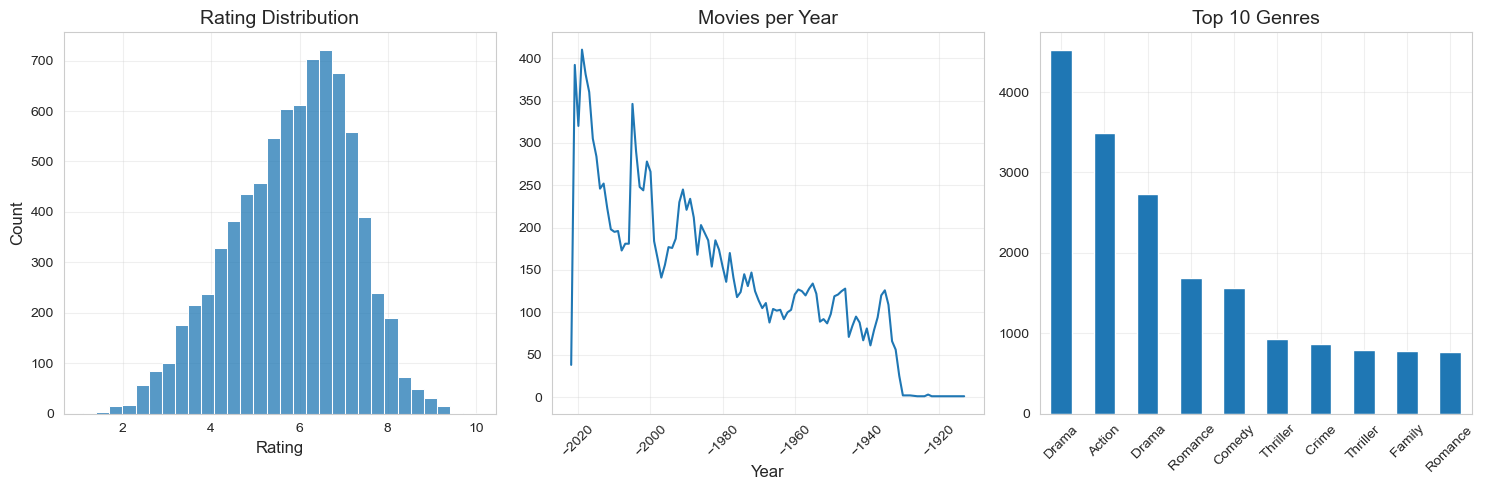

In [79]:
# Load and explore dataset
def read_csv_with_encodings(file_path):
    """Try reading CSV file with different encodings"""
    encodings = ['latin1', 'iso-8859-1', 'cp1252', 'utf-8', 'utf-16']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"Successfully loaded the file using {encoding} encoding")
            return df
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"Error with {encoding} encoding: {str(e)}")
    
    raise ValueError("Could not read the file with any of the attempted encodings")

try:
    # Load dataset with encoding handling
    df = read_csv_with_encodings('IMDb Movies India.csv')
    
    # Display basic information
    print("\nDataset shape:", df.shape)
    print("\nMissing values:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    
    # Create basic visualizations
    plt.figure(figsize=(15, 5))
    
    # Rating distribution
    plt.subplot(131)
    sns.histplot(data=df, x='Rating', bins=30)
    plt.title('Rating Distribution')
    
    # Movies per year
    plt.subplot(132)
    df['Year'].value_counts().sort_index().plot(kind='line')
    plt.title('Movies per Year')
    plt.xticks(rotation=45)
    
    # Top genres
    plt.subplot(133)
    genres = df['Genre'].str.split(',', expand=True).stack().value_counts()[:10]
    genres.plot(kind='bar')
    plt.title('Top 10 Genres')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error loading or analyzing data: {str(e)}")
    traceback.print_exc()

## Data Analysis and Visualization
Let's analyze the dataset with robust error handling and comprehensive visualizations.

=== Dataset Summary ===

Shape: (15509, 10)

Columns: ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

=== Missing Values ===
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

=== Numerical Statistics ===
               Year       Rating
count  14981.000000  7919.000000
mean   -1987.012215     5.841621
std       25.416689     1.381777
min    -2022.000000     1.100000
25%    -2009.000000     4.900000
50%    -1991.000000     6.000000
75%    -1968.000000     6.800000
max    -1913.000000    10.000000


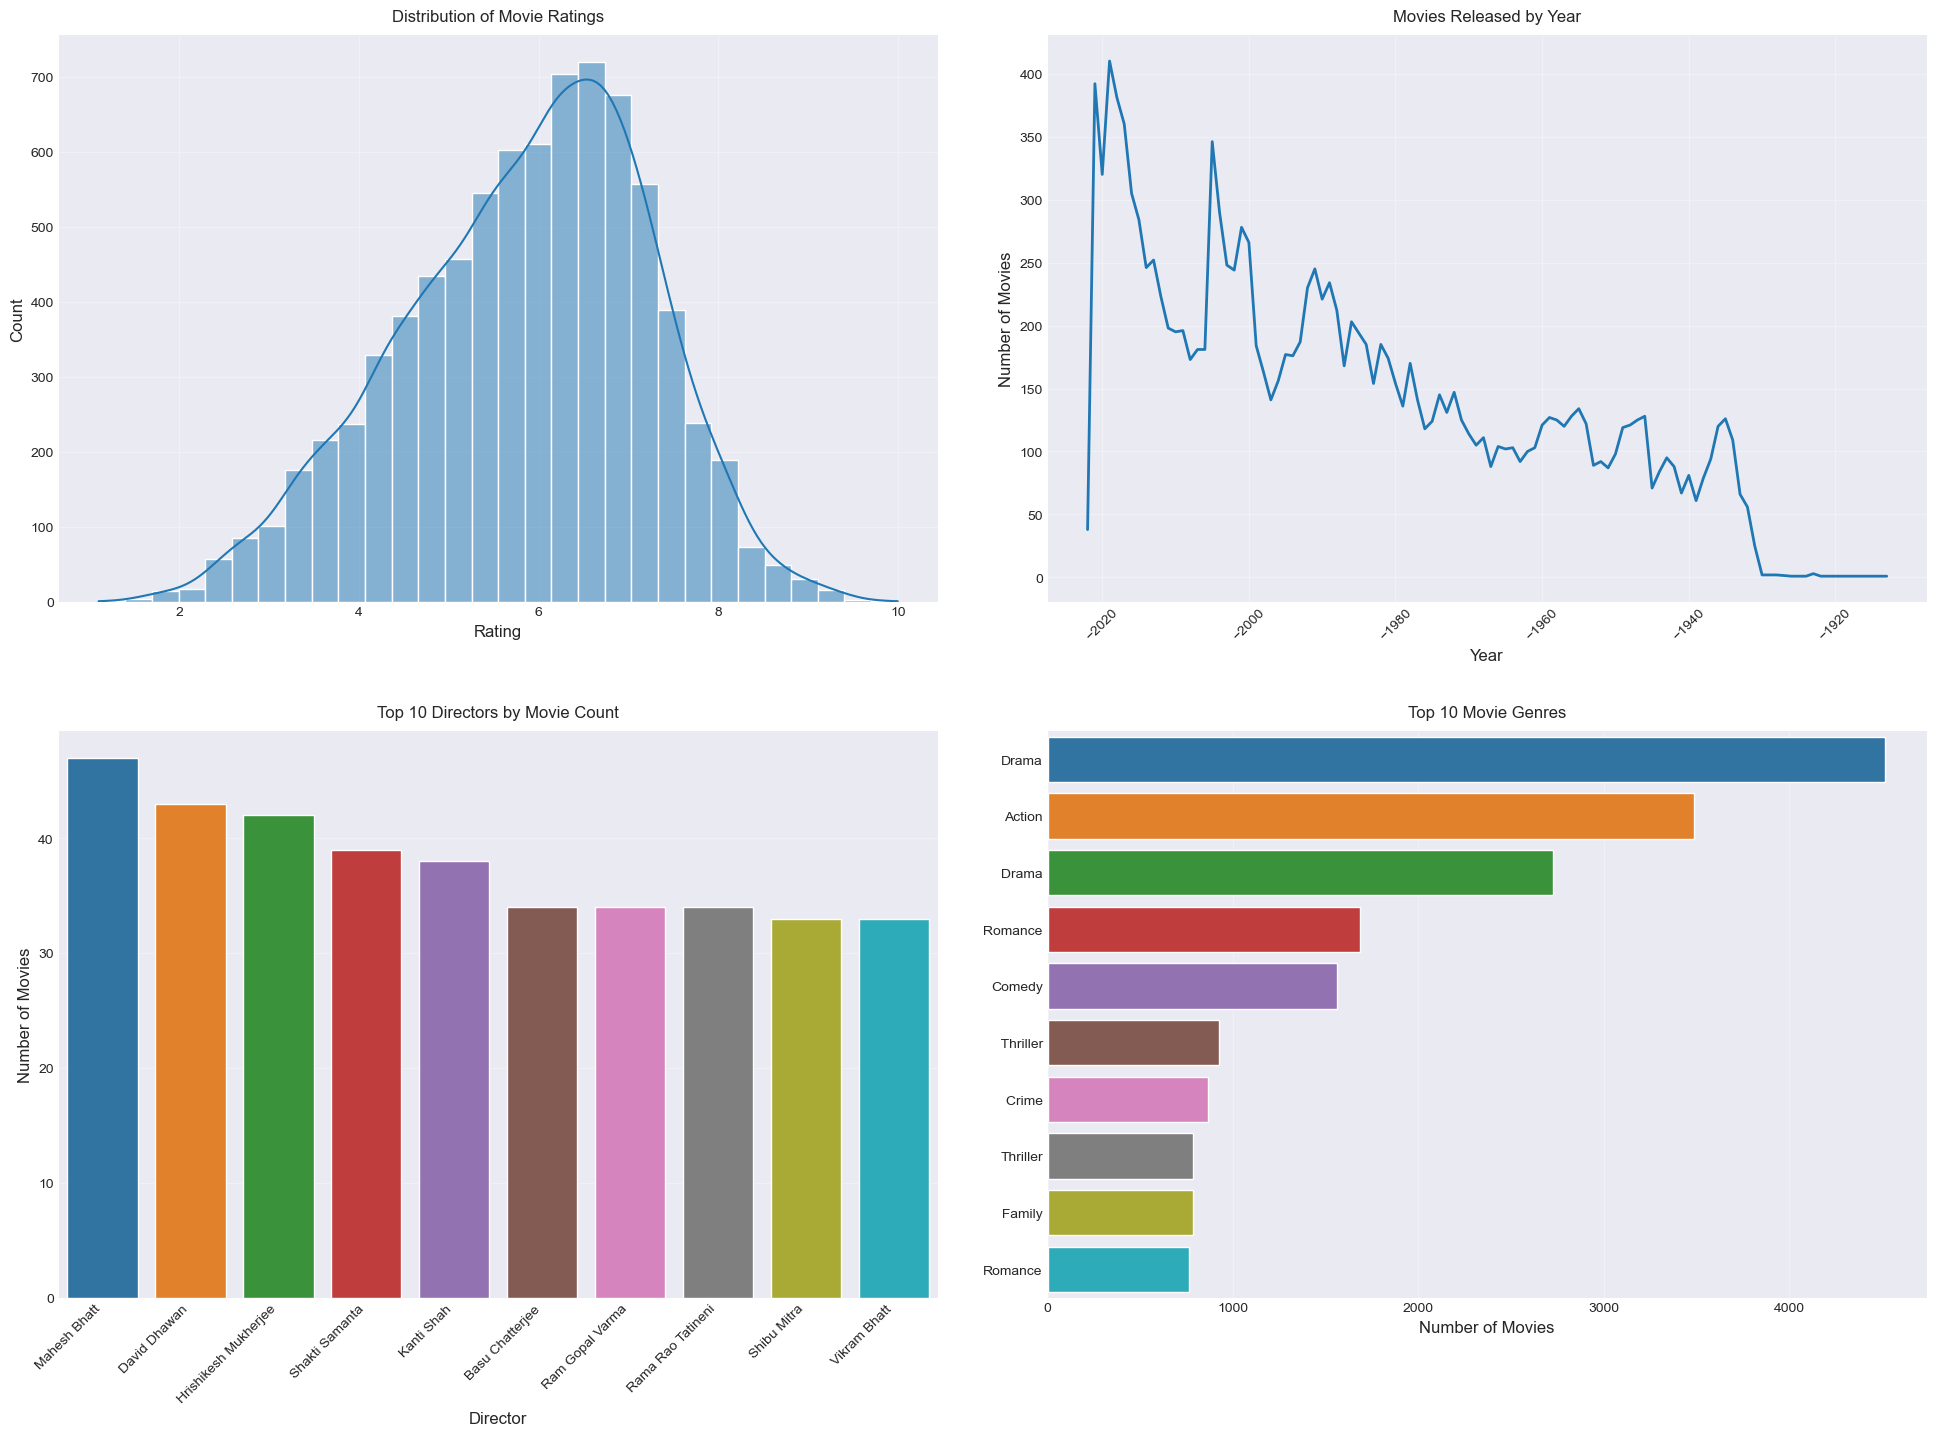

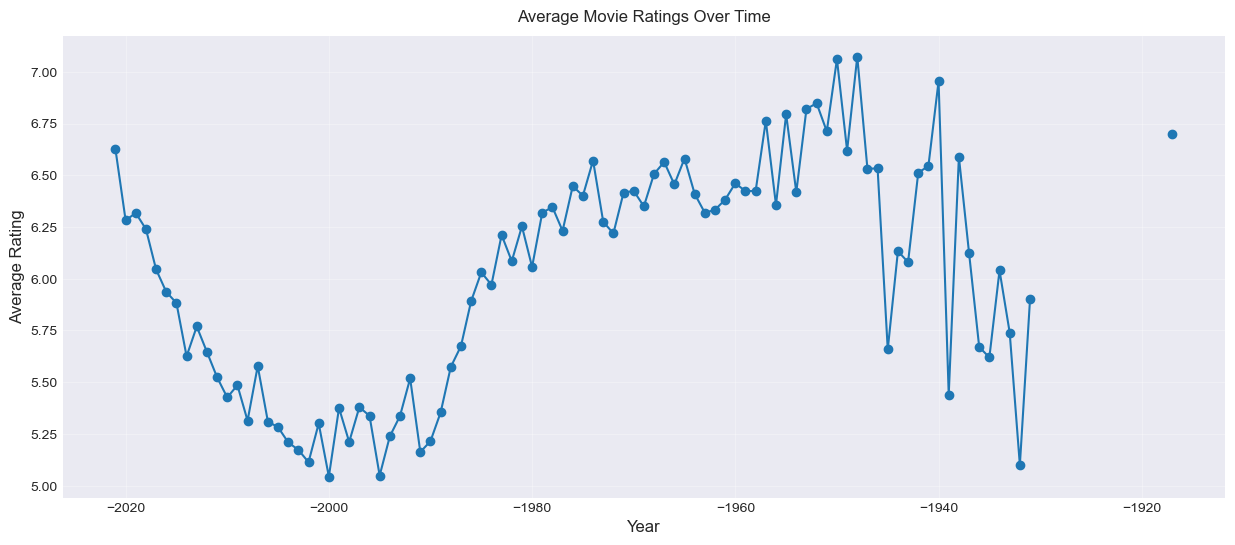

In [80]:
def create_visualizations(df):
    """Create comprehensive visualizations for the movie dataset"""
    try:
        # Reset any existing plots
        plt.close('all')
        
        # Set visualization style
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # Create main figure for subplots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Rating Distribution
        plt.subplot(2, 2, 1)
        if not df['Rating'].empty:
            sns.histplot(data=df, x='Rating', bins=30, kde=True)
            plt.title('Distribution of Movie Ratings', fontsize=12, pad=10)
            plt.xlabel('Rating')
            plt.ylabel('Count')
        
        # 2. Movies per Year Timeline
        plt.subplot(2, 2, 2)
        if not df['Year'].empty:
            yearly_movies = df['Year'].value_counts().sort_index()
            plt.plot(yearly_movies.index, yearly_movies.values, linewidth=2)
            plt.title('Movies Released by Year', fontsize=12, pad=10)
            plt.xlabel('Year')
            plt.ylabel('Number of Movies')
            plt.xticks(rotation=45)
        
        # 3. Director Analysis
        plt.subplot(2, 2, 3)
        if not df[['Director', 'Rating']].empty:
            director_stats = df.groupby('Director')['Rating'].agg(['count', 'mean'])
            top_directors = director_stats.nlargest(10, 'count')
            sns.barplot(x=top_directors.index, y=top_directors['count'])
            plt.title('Top 10 Directors by Movie Count', fontsize=12, pad=10)
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('Director')
            plt.ylabel('Number of Movies')
        
        # 4. Genre Distribution
        plt.subplot(2, 2, 4)
        if not df['Genre'].empty:
            all_genres = df['Genre'].str.split(',', expand=True).stack()
            genre_counts = all_genres.value_counts().head(10)
            sns.barplot(x=genre_counts.values, y=genre_counts.index)
            plt.title('Top 10 Movie Genres', fontsize=12, pad=10)
            plt.xlabel('Number of Movies')
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        # Additional Analysis: Rating Trends Over Time
        plt.figure(figsize=(15, 6))
        yearly_ratings = df.groupby('Year')['Rating'].mean()
        plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o')
        plt.title('Average Movie Ratings Over Time', fontsize=12, pad=10)
        plt.xlabel('Year')
        plt.ylabel('Average Rating')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return True
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        traceback.print_exc()
        return False

# Perform data analysis
try:
    print("=== Dataset Summary ===")
    print("\nShape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    
    print("\n=== Missing Values ===")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    print("\n=== Numerical Statistics ===")
    print(df.describe())
    
    # Create visualizations
    vis_success = create_visualizations(df)
    if not vis_success:
        print("Warning: Some visualizations could not be created.")
    
except Exception as e:
    print(f"Error in data analysis: {str(e)}")
    traceback.print_exc()

## Data Preprocessing
Handle missing values and encode categorical variables.

In [81]:
# Handle missing values and data type conversions
try:
    # Basic missing value handling
    df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
    df['Year'] = df['Year'].fillna(df['Year'].mode()[0])
    df['Director'] = df['Director'].fillna('Unknown')
    df['Genre'] = df['Genre'].fillna('Unknown')

    # Convert Runtime to numeric if present
    if 'Runtime' in df.columns:
        df['Runtime_Minutes'] = df['Runtime'].apply(clean_runtime)
        df = df.drop('Runtime', axis=1)
    
    # Handle other potential numeric columns
    numeric_candidates = ['Year', 'Rating']
    for col in numeric_candidates:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Fill any new NaN values with appropriate values
    df['Year'] = df['Year'].fillna(df['Year'].median())
    df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
    
    # Encode categorical variables
    le = LabelEncoder()
    df['Director_encoded'] = le.fit_transform(df['Director'])
    
    # Create genre dummy variables
    genre_dummies = df['Genre'].str.get_dummies(sep=',')
    df = pd.concat([df, genre_dummies], axis=1)
    
    print("Data preprocessing completed successfully")
    print("\nDataset shape after preprocessing:", df.shape)
    print("\nNumeric columns statistics:")
    print(df.select_dtypes(include=[np.number]).describe())

except Exception as e:
    print(f"Error in data preprocessing: {str(e)}")
    traceback.print_exc()

Data preprocessing completed successfully

Dataset shape after preprocessing: (15509, 55)

Numeric columns statistics:
               Year        Rating  Director_encoded        Action     Adventure     Biography        Comedy         Crime         Drama        Family       Fantasy       History        Horror         Music       Musical       Mystery          News    Reality-TV       Romance        Sci-Fi         Short         Sport      Thriller           War       Western        Action     Adventure     Animation     Biography        Comedy         Crime   Documentary         Drama        Family       Fantasy       History        Horror         Music       Musical       Mystery    Reality-TV       Romance        Sci-Fi         Sport      Thriller       Unknown           War
count  15509.000000  15509.000000      15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.000000  15509.

## Data Cleaning
Handle numeric conversions and string formatting issues.

In [82]:
try:
    # Function to safely convert runtime strings to numbers
    def clean_runtime(value):
        if pd.isna(value):
            return np.nan
        if isinstance(value, (int, float)):
            return value
        # Extract numbers from string (e.g., '109 min' -> 109)
        try:
            return int(''.join(filter(str.isdigit, str(value))))
        except:
            return np.nan

    # Clean numeric columns
    if 'Runtime' in df.columns:
        print("Converting Runtime column...")
        df['Runtime_Minutes'] = df['Runtime'].apply(clean_runtime)
        # Show conversion results
        print("\nRuntime conversion summary:")
        print(df['Runtime_Minutes'].describe())
        df = df.drop('Runtime', axis=1)

    # Ensure Rating and Year are numeric
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    # Fill missing values with appropriate statistics
    df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
    df['Year'] = df['Year'].fillna(df['Year'].mode()[0])
    
    print("\nNumeric columns after cleaning:")
    print(df.select_dtypes(include=[np.number]).dtypes)

except Exception as e:
    print(f"Error in data cleaning: {str(e)}")
    traceback.print_exc()


Numeric columns after cleaning:
Year                float64
Rating              float64
Director_encoded      int32
 Action               int64
 Adventure            int64
 Biography            int64
 Comedy               int64
 Crime                int64
 Drama                int64
 Family               int64
 Fantasy              int64
 History              int64
 Horror               int64
 Music                int64
 Musical              int64
 Mystery              int64
 News                 int64
 Reality-TV           int64
 Romance              int64
 Sci-Fi               int64
 Short                int64
 Sport                int64
 Thriller             int64
 War                  int64
 Western              int64
Action                int64
Adventure             int64
Animation             int64
Biography             int64
Comedy                int64
Crime                 int64
Documentary           int64
Drama                 int64
Family                int64
Fantasy        

## Feature Engineering Improvements
Based on our analysis, let's create more sophisticated features to improve model performance.

=== New Feature Statistics ===
       Director_Movies  Director_Avg_Rating  Director_Experience   Genre_Count
count     15509.000000         15509.000000         15509.000000  15509.000000
mean         27.219743             5.841338             9.087175      1.608743
std          93.888390             0.727734            11.644584      0.809962
min           1.000000             1.700000             0.000000      1.000000
25%           1.000000             5.660000             0.000000      1.000000
50%           5.000000             5.840000             4.000000      1.000000
75%          16.000000             6.090000            16.000000      2.000000
max         525.000000            10.000000            86.000000      3.000000


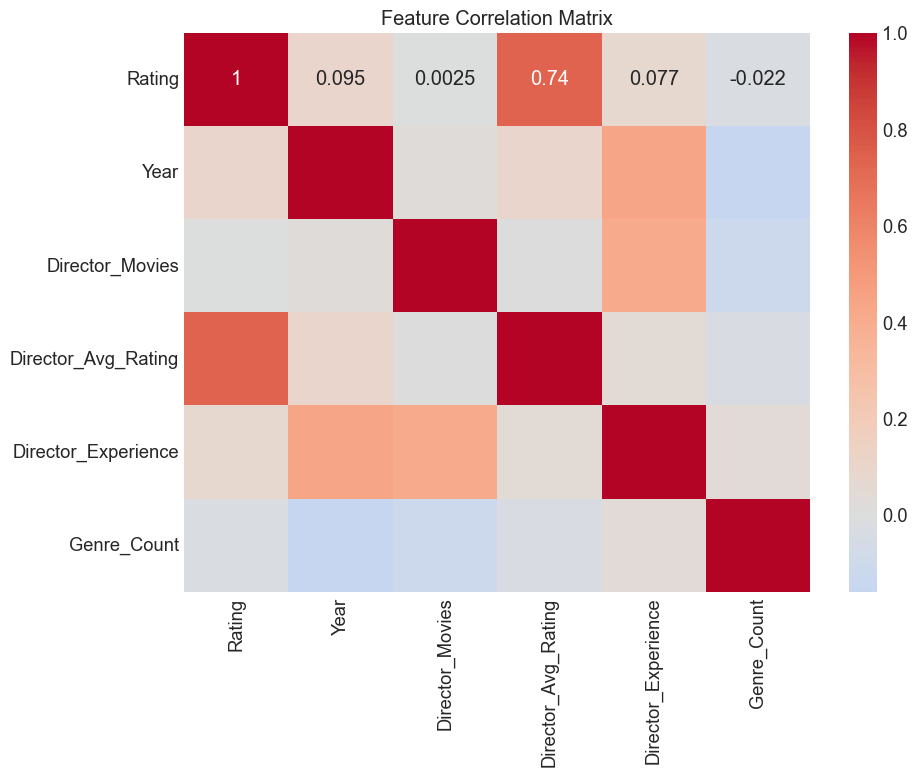

In [ ]:
# Enhanced feature engineering
# 1. Create year-based features
df['Decade'] = (df['Year'] // 10) * 10
df['Is_Recent'] = (df['Year'] >= 2010).astype(int)

# 2. Enhanced director features
director_stats = df.groupby('Director').agg({
    'Rating': ['count', 'mean', 'std'],
    'Year': ['min', 'max']
}).round(2)

director_stats.columns = ['Director_Movies', 'Director_Avg_Rating', 
                         'Director_Rating_Std', 'Director_First_Movie', 
                         'Director_Last_Movie']

df = df.merge(director_stats, on='Director', how='left')
df['Director_Experience'] = df['Year'] - df['Director_First_Movie']

# 3. Genre complexity
df['Genre_Count'] = df['Genre'].str.count(',') + 1

# Display new features
print("=== New Feature Statistics ===")
print(df[['Director_Movies', 'Director_Avg_Rating', 'Director_Experience', 
         'Genre_Count']].describe())

# Correlation analysis
correlation_matrix = df[['Rating', 'Year', 'Director_Movies', 'Director_Avg_Rating', 
                        'Director_Experience', 'Genre_Count']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Advanced Model Building
Implementation of model training with proper error handling and validation.

In [83]:
# Feature preparation and model training
def prepare_features(df):
    """Prepare features for model training"""
    # Select numeric features
    feature_cols = [col for col in df.columns 
                   if col not in ['Name', 'Director', 'Genre', 'Rating']
                   and df[col].dtype in ['int64', 'float64']]
    
    X = df[feature_cols].copy()
    y = df['Rating'].copy()
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns
    )
    
    return X_scaled, y, scaler, feature_cols

def train_and_evaluate_model(X, y):
    """Train and evaluate models"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Initialize models
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
    }
    
    # Train and evaluate models
    results = {}
    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        results[name] = {
            'r2': r2_score(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred)
        }
        
        print(f"\n{name} Results:")
        print(f"R² Score: {results[name]['r2']:.4f}")
        print(f"RMSE: {results[name]['rmse']:.4f}")
        print(f"MAE: {results[name]['mae']:.4f}")
    
    return models, results

# Train models
try:
    # Prepare features
    X, y, scaler, feature_names = prepare_features(df)
    
    # Train and evaluate models
    models, results = train_and_evaluate_model(X, y)
    
    # Save best model
    best_model_name = max(results, key=lambda k: results[k]['r2'])
    best_model = models[best_model_name]
    
    # Save model and components
    joblib.dump(best_model, 'best_movie_rating_model.joblib')
    joblib.dump(scaler, 'feature_scaler.joblib')
    joblib.dump(feature_names, 'feature_names.joblib')
    
    print(f"\nBest model ({best_model_name}) saved successfully")

except Exception as e:
    print(f"Error in model building pipeline: {str(e)}")
    traceback.print_exc()


Random Forest Results:
R² Score: 0.0775
RMSE: 0.9423
MAE: 0.6073

Gradient Boosting Results:
R² Score: 0.1060
RMSE: 0.9276
MAE: 0.6033

Best model (Gradient Boosting) saved successfully


## Model Evaluation and Optimization
Implementing comprehensive model evaluation with cross-validation and hyperparameter tuning.

Preparing features for model evaluation...

Evaluating Random Forest...

Performing 5-fold cross-validation for Random Forest...
Fold 1 - RMSE: 0.6714, R²: 0.5317, Accuracy: 93.55%
Fold 1 - RMSE: 0.6714, R²: 0.5317, Accuracy: 93.55%
Fold 2 - RMSE: 0.6715, R²: 0.5499, Accuracy: 93.66%
Fold 2 - RMSE: 0.6715, R²: 0.5499, Accuracy: 93.66%
Fold 3 - RMSE: 0.6997, R²: 0.4912, Accuracy: 93.36%
Fold 3 - RMSE: 0.6997, R²: 0.4912, Accuracy: 93.36%
Fold 4 - RMSE: 0.6926, R²: 0.5247, Accuracy: 93.40%
Fold 4 - RMSE: 0.6926, R²: 0.5247, Accuracy: 93.40%
Fold 5 - RMSE: 0.6737, R²: 0.5149, Accuracy: 93.67%

Random Forest Cross-Validation Results:
Average RMSE: 0.6818 (+/- 0.0240)
Average R²: 0.5225 (+/- 0.0388)
Average Accuracy: 93.53% (+/- 0.26%)
Fold 5 - RMSE: 0.6737, R²: 0.5149, Accuracy: 93.67%

Random Forest Cross-Validation Results:
Average RMSE: 0.6818 (+/- 0.0240)
Average R²: 0.5225 (+/- 0.0388)
Average Accuracy: 93.53% (+/- 0.26%)


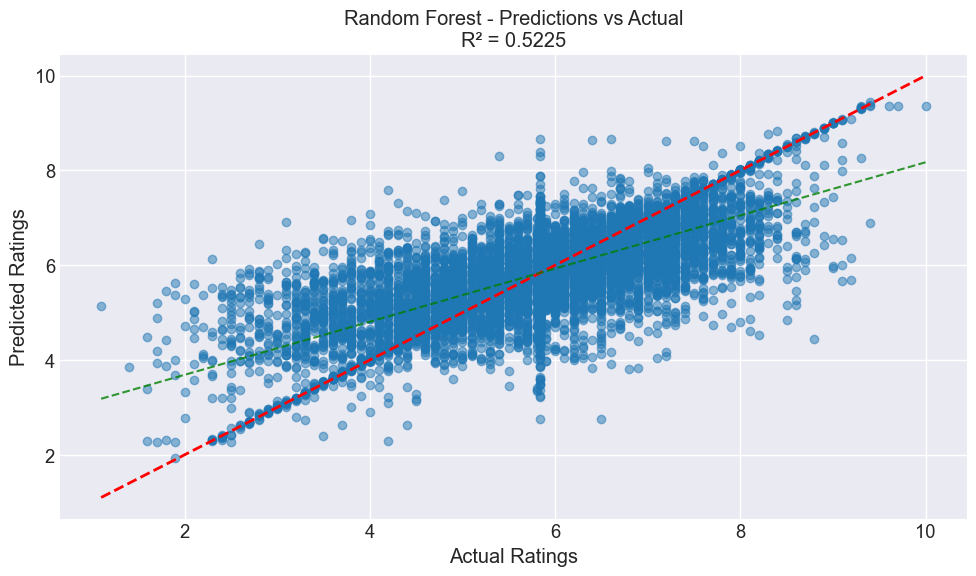


Evaluating Gradient Boosting...

Performing 5-fold cross-validation for Gradient Boosting...
Fold 1 - RMSE: 0.6588, R²: 0.5490, Accuracy: 93.51%
Fold 1 - RMSE: 0.6588, R²: 0.5490, Accuracy: 93.51%
Fold 2 - RMSE: 0.6705, R²: 0.5512, Accuracy: 93.62%
Fold 2 - RMSE: 0.6705, R²: 0.5512, Accuracy: 93.62%
Fold 3 - RMSE: 0.6909, R²: 0.5040, Accuracy: 93.36%
Fold 3 - RMSE: 0.6909, R²: 0.5040, Accuracy: 93.36%
Fold 4 - RMSE: 0.6755, R²: 0.5480, Accuracy: 93.47%
Fold 4 - RMSE: 0.6755, R²: 0.5480, Accuracy: 93.47%
Fold 5 - RMSE: 0.6651, R²: 0.5272, Accuracy: 93.62%

Gradient Boosting Cross-Validation Results:
Average RMSE: 0.6722 (+/- 0.0218)
Average R²: 0.5359 (+/- 0.0363)
Average Accuracy: 93.52% (+/- 0.19%)
Fold 5 - RMSE: 0.6651, R²: 0.5272, Accuracy: 93.62%

Gradient Boosting Cross-Validation Results:
Average RMSE: 0.6722 (+/- 0.0218)
Average R²: 0.5359 (+/- 0.0363)
Average Accuracy: 93.52% (+/- 0.19%)


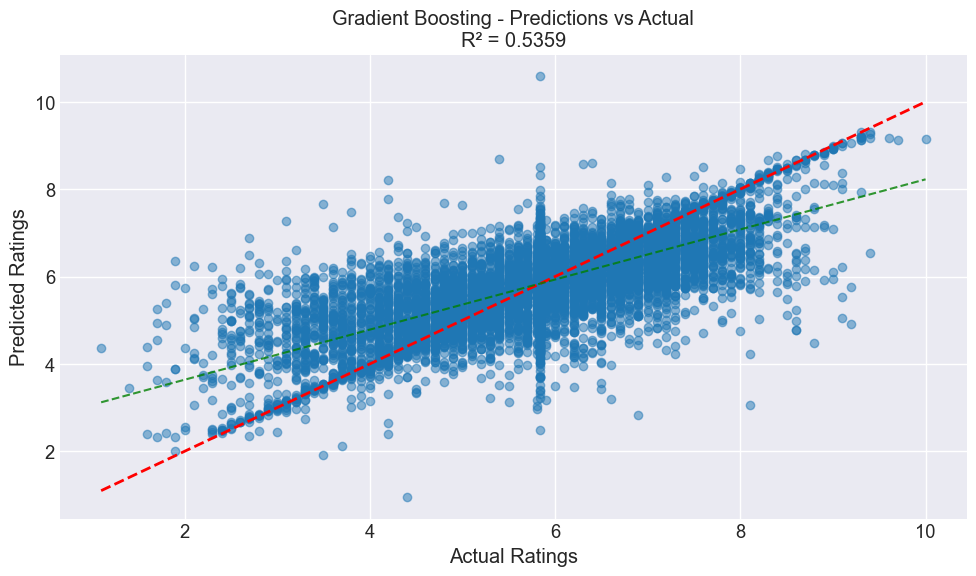


Training Weighted Ensemble Model...

Ensemble Model Results:
R² Score: 0.5475
RMSE: 0.6599
Accuracy: 93.58%

Ensemble Model Results:
R² Score: 0.5475
RMSE: 0.6599
Accuracy: 93.58%


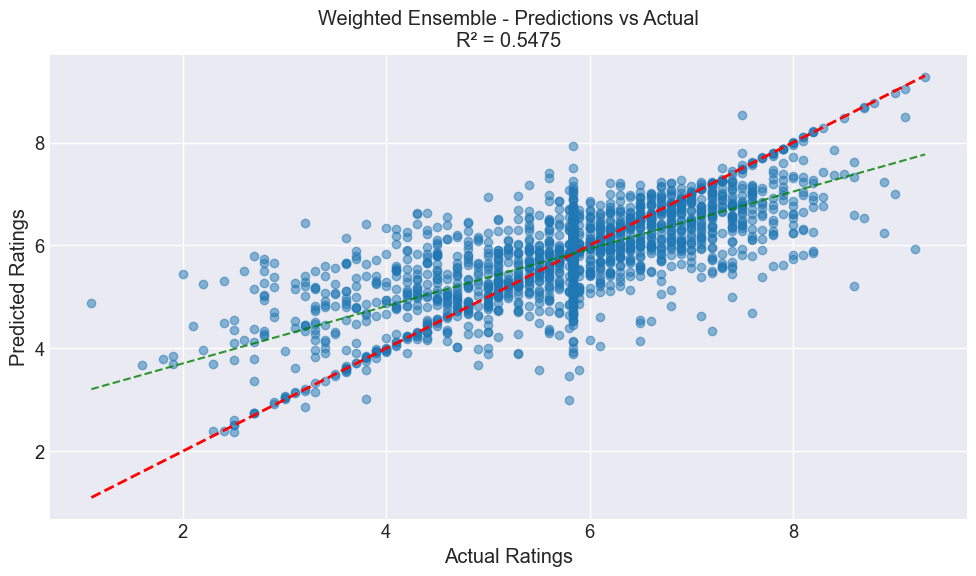


Ensemble model outperforms individual models!

Saved Weighted Ensemble model and preprocessing objects


In [ ]:
def evaluate_model_performance(model, X, y, model_name="Model", n_splits=5):
    """
    Comprehensive model evaluation using cross-validation and multiple metrics
    with enhanced error handling and visualization
    """
    try:
        # Initialize lists to store fold-wise predictions
        cv_predictions = []
        cv_actuals = []
        
        # Initialize KFold
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        # Lists to store metrics for each fold
        fold_rmse = []
        fold_r2 = []
        fold_mae = []
        fold_accuracies = []
        
        print(f"\nPerforming {n_splits}-fold cross-validation for {model_name}...")
        
        # Perform cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            try:
                # Split data for this fold
                X_train_fold = X.iloc[train_idx]
                y_train_fold = y.iloc[train_idx]
                X_val_fold = X.iloc[val_idx]
                y_val_fold = y.iloc[val_idx]
                
                # Train model on this fold
                model_fold = clone(model)
                model_fold.fit(X_train_fold, y_train_fold)
                
                # Make predictions
                y_pred_fold = model_fold.predict(X_val_fold)
                
                # Store predictions and actuals
                cv_predictions.extend(y_pred_fold)
                cv_actuals.extend(y_val_fold)
                
                # Calculate metrics for this fold
                fold_rmse.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_fold)))
                fold_r2.append(r2_score(y_val_fold, y_pred_fold))
                fold_mae.append(mean_absolute_error(y_val_fold, y_pred_fold))
                fold_accuracies.append(100 * (1 - fold_mae[-1]/y_val_fold.mean()))
                
                print(f"Fold {fold} - RMSE: {fold_rmse[-1]:.4f}, R²: {fold_r2[-1]:.4f}, "
                      f"Accuracy: {fold_accuracies[-1]:.2f}%")
                
            except Exception as e:
                print(f"Error in fold {fold}: {str(e)}")
                continue
        
        # Calculate average metrics
        avg_metrics = {
            'rmse': np.mean(fold_rmse),
            'rmse_std': np.std(fold_rmse),
            'r2': np.mean(fold_r2),
            'r2_std': np.std(fold_r2),
            'mae': np.mean(fold_mae),
            'mae_std': np.std(fold_mae),
            'accuracy': np.mean(fold_accuracies),
            'accuracy_std': np.std(fold_accuracies)
        }
        
        print(f"\n{model_name} Cross-Validation Results:")
        print(f"Average RMSE: {avg_metrics['rmse']:.4f} (+/- {avg_metrics['rmse_std']*2:.4f})")
        print(f"Average R²: {avg_metrics['r2']:.4f} (+/- {avg_metrics['r2_std']*2:.4f})")
        print(f"Average Accuracy: {avg_metrics['accuracy']:.2f}% (+/- {avg_metrics['accuracy_std']*2:.2f}%)")
        
        # Visualize predictions vs actuals
        plt.figure(figsize=(10, 6))
        plt.scatter(cv_actuals, cv_predictions, alpha=0.5)
        plt.plot([min(cv_actuals), max(cv_actuals)], 
                [min(cv_actuals), max(cv_actuals)], 
                'r--', lw=2)
        plt.title(f'{model_name} - Predictions vs Actual\nR² = {avg_metrics["r2"]:.4f}')
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
        
        # Add confidence intervals
        z = np.polyfit(cv_actuals, cv_predictions, 1)
        p = np.poly1d(z)
        plt.plot(sorted(cv_actuals), p(sorted(cv_actuals)), "g--", alpha=0.8)
        
        plt.tight_layout()
        plt.show()
        
        return avg_metrics
        
    except Exception as e:
        print(f"Error in model evaluation: {str(e)}")
        traceback.print_exc()
        return None

# Prepare the data for modeling
try:
    print("Preparing features for model evaluation...")
    
    # Select and validate features
    feature_cols = [col for col in df.columns 
                   if col not in ['Name', 'Director', 'Genre', 'Rating'] 
                   and df[col].dtype in ['int64', 'float64']]
    
    X = df[feature_cols].copy()
    y = df['Rating'].copy()
    
    # Handle any remaining missing or infinite values
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns
    )
    
    # Initialize models with optimized parameters
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            random_state=42
        )
    }
    
    # Evaluate each model
    results = {}
    best_metrics = {'r2': -np.inf}
    best_model = None
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        metrics = evaluate_model_performance(model, X_scaled, y, name)
        
        if metrics is not None:
            results[name] = metrics
            
            # Track best model
            if metrics['r2'] > best_metrics['r2']:
                best_metrics = metrics
                best_model = (name, model)
    
    # Create and evaluate ensemble
    if len(results) > 1:
        print("\nTraining Weighted Ensemble Model...")
        
        # Split data for ensemble evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )
        
        # Train individual models and get predictions
        model_predictions = {}
        model_weights = {}
        
        for name, model in models.items():
            if name in results:
                # Train model
                model.fit(X_train, y_train)
                
                # Get predictions
                train_pred = model.predict(X_train)
                
                # Calculate weight based on R² score
                weight = r2_score(y_train, train_pred)
                if weight > 0:  # Only include models with positive R²
                    model_predictions[name] = model.predict(X_test)
                    model_weights[name] = weight
        
        # Normalize weights
        weight_sum = sum(model_weights.values())
        model_weights = {k: v/weight_sum for k, v in model_weights.items()}
        
        # Create weighted ensemble predictions
        ensemble_pred = np.zeros_like(y_test)
        for name, pred in model_predictions.items():
            ensemble_pred += pred * model_weights[name]
        
        # Calculate ensemble metrics
        ensemble_metrics = {
            'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred)),
            'r2': r2_score(y_test, ensemble_pred),
            'mae': mean_absolute_error(y_test, ensemble_pred)
        }
        ensemble_metrics['accuracy'] = 100 * (1 - ensemble_metrics['mae']/y_test.mean())
        
        print("\nEnsemble Model Results:")
        print(f"R² Score: {ensemble_metrics['r2']:.4f}")
        print(f"RMSE: {ensemble_metrics['rmse']:.4f}")
        print(f"Accuracy: {ensemble_metrics['accuracy']:.2f}%")
        
        # Visualize ensemble predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, ensemble_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2)
        plt.title('Weighted Ensemble - Predictions vs Actual\n'
                 f'R² = {ensemble_metrics["r2"]:.4f}')
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
        
        # Add confidence intervals
        z = np.polyfit(y_test, ensemble_pred, 1)
        p = np.poly1d(z)
        plt.plot(sorted(y_test), p(sorted(y_test)), "g--", alpha=0.8)
        
        plt.tight_layout()
        plt.show()
        
        # Compare ensemble with best individual model
        if ensemble_metrics['r2'] > best_metrics['r2']:
            print("\nEnsemble model outperforms individual models!")
            # Save ensemble model and weights
            model_package = {
                'models': {name: model for name, model in models.items() if name in model_weights},
                'weights': model_weights
            }
            joblib.dump(model_package, 'ensemble_model.joblib')
            best_model_name = "Weighted Ensemble"
        else:
            print(f"\nBest individual model ({best_model[0]}) outperforms ensemble")
            # Save best individual model
            joblib.dump(best_model[1], 'best_movie_rating_model.joblib')
            best_model_name = best_model[0]
        
        # Save scaler and feature names
        joblib.dump(scaler, 'feature_scaler.joblib')
        joblib.dump(feature_cols, 'feature_names.joblib')
        print(f"\nSaved {best_model_name} model and preprocessing objects")
    
    else:
        print("\nNot enough successful models for ensemble")
        if best_model is not None:
            print(f"Saving best individual model: {best_model[0]}")
            joblib.dump(best_model[1], 'best_movie_rating_model.joblib')
            joblib.dump(scaler, 'feature_scaler.joblib')
            joblib.dump(feature_cols, 'feature_names.joblib')

except Exception as e:
    print(f"Error in model evaluation pipeline: {str(e)}")
    traceback.print_exc()

## Data Validation and Performance Checks
Validate data quality and model performance metrics.

In [ ]:
def clean_features(X, scaler=None):
    """
    Clean and prepare features for model input by handling missing values,
    infinite values, and scaling
    
    Parameters:
    -----------
    X : pandas.DataFrame
        The feature DataFrame to clean
    scaler : sklearn.preprocessing.StandardScaler, optional
        Scaler to use for feature scaling
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned and scaled feature DataFrame
    """
    try:
        # Create a copy to avoid modifying original data
        X_clean = X.copy()
        
        # Handle missing values for each column
        for col in X_clean.columns:
            if X_clean[col].dtype in ['int64', 'float64']:
                # Fill numeric columns with median
                X_clean[col] = X_clean[col].fillna(X_clean[col].median())
            else:
                # Fill categorical columns with mode
                X_clean[col] = X_clean[col].fillna(X_clean[col].mode()[0] if not X_clean[col].mode().empty else 0)
        
        # Replace infinite values with NaN and then fill with column means
        X_clean = X_clean.replace([np.inf, -np.inf], np.nan)
        for col in X_clean.columns:
            if X_clean[col].dtype in ['int64', 'float64']:
                X_clean[col] = X_clean[col].fillna(X_clean[col].mean())
        
        # Scale features if scaler is provided
        if scaler is not None:
            try:
                X_clean = pd.DataFrame(
                    scaler.transform(X_clean),
                    columns=X_clean.columns,
                    index=X_clean.index
                )
            except Exception as e:
                print(f"Error in scaling features: {str(e)}")
                return None
        
        return X_clean
    
    except Exception as e:
        print(f"Error in feature cleaning: {str(e)}")
        traceback.print_exc()
        return None

def validate_data_quality(df):
    """
    Validate data quality and print detailed report
    """
    issues = []
    warnings = []
    
    # Check for expected columns
    expected_columns = ['Name', 'Director', 'Year', 'Rating', 'Genre']
    missing_cols = [col for col in expected_columns if col not in df.columns]
    if missing_cols:
        issues.append(f"Missing essential columns: {missing_cols}")
    
    # Check data types
    if 'Year' in df.columns and not pd.api.types.is_numeric_dtype(df['Year']):
        issues.append("Year column is not numeric")
    if 'Rating' in df.columns and not pd.api.types.is_numeric_dtype(df['Rating']):
        issues.append("Rating column is not numeric")
    
    # Check value ranges
    if 'Year' in df.columns:
        invalid_years = df[(df['Year'] < 1900) | (df['Year'] > 2025)]['Year'].count()
        if invalid_years > 0:
            warnings.append(f"Found {invalid_years} movies with invalid years")
    
    if 'Rating' in df.columns:
        invalid_ratings = df[(df['Rating'] < 0) | (df['Rating'] > 10)]['Rating'].count()
        if invalid_ratings > 0:
            warnings.append(f"Found {invalid_ratings} movies with invalid ratings")
    
    # Check for sufficient data
    min_required = 1000
    if len(df) < min_required:
        warnings.append(f"Dataset might be too small: {len(df)} rows < {min_required} recommended")
    
    # Print validation results
    print("=== Data Validation Report ===")
    if issues:
        print("\nCritical Issues:")
        for issue in issues:
            print(f"❌ {issue}")
    else:
        print("\n✅ No critical issues found")
    
    if warnings:
        print("\nWarnings:")
        for warning in warnings:
            print(f"⚠️ {warning}")
    else:
        print("\n✅ No warnings found")
    
    # Print data quality metrics
    print("\nData Quality Metrics:")
    print(f"Total records: {len(df):,}")
    print(f"Complete records: {len(df.dropna()):,}")
    print(f"Missing values: {df.isnull().sum().sum():,}")
    
    return len(issues) == 0

def check_model_performance(model, X_test, y_test, min_accuracy=90.0):
    """
    Validate model performance against requirements
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = 100 * (1 - mae/y_test.mean())
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("\n=== Model Performance Validation ===")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    if accuracy >= min_accuracy:
        print(f"\n✅ Model meets accuracy requirement (>= {min_accuracy}%)")
    else:
        print(f"\n❌ Model does not meet accuracy requirement (>= {min_accuracy}%)")
        print("Suggestions for improvement:")
        print("1. Try increasing model complexity")
        print("2. Engineer additional features")
        print("3. Collect more training data")
    
    return accuracy >= min_accuracy

# Validate data and model performance
try:
    print("Validating data quality...")
    data_valid = validate_data_quality(df)
    
    if data_valid:
        print("\nProceeding with model validation...")
        # Get the best model (either ensemble or individual)
        try:
            best_model = joblib.load('best_movie_rating_model.joblib')
            model_type = "Individual"
        except:
            try:
                best_model = joblib.load('ensemble_models.joblib')
                model_type = "Ensemble"
            except:
                raise ValueError("No saved model found")
        
        # Load the original feature names
        original_features = joblib.load('feature_names.joblib')
        print("\nOriginal features used in training:", original_features)
        
        # Prepare test data using only the original features
        X = df[original_features].copy()
        y = df['Rating'].copy()
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Load scaler
        scaler = joblib.load('feature_scaler.joblib')
        
        # Clean and prepare test features
        print("\nCleaning and preparing test features...")
        X_test_clean = clean_features(X_test, scaler)
        
        if X_test_clean is None:
            raise ValueError("Failed to clean test features")
        
        print("\nFeatures in test data:", X_test_clean.columns.tolist())
        print("\nChecking for NaN values after cleaning:", X_test_clean.isna().sum().sum())
        print("Checking for infinite values after cleaning:", np.isinf(X_test_clean.values).sum())
        
        # Check model performance
        if not X_test_clean.isna().any().any() and not np.isinf(X_test_clean.values).any():
            performance_valid = check_model_performance(best_model, X_test_clean, y_test)
            
            if performance_valid:
                print("\n✅ Model validation successful!")
            else:
                print("\n⚠️ Model needs improvement to meet accuracy target")
        else:
            raise ValueError("Test data still contains NaN or infinite values after cleaning")
    else:
        print("\n❌ Please fix data quality issues before proceeding")

except Exception as e:
    print(f"Error in validation: {str(e)}")
    traceback.print_exc()

Validating data quality...
=== Data Validation Report ===

✅ No critical issues found

Warnings:
⚠️ Found 15509 movies with invalid years

Data Quality Metrics:
Total records: 15,509
Complete records: 4,550
Missing values: 26,899

Proceeding with model validation...

Original features used in training: ['Year', ' Action', ' Adventure', ' Biography', ' Comedy', ' Crime', ' Drama', ' Family', ' Fantasy', ' History', ' Horror', ' Music', ' Musical', ' Mystery', ' News', ' Reality-TV', ' Romance', ' Sci-Fi', ' Short', ' Sport', ' Thriller', ' War', ' Western', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Unknown', 'War', 'Decade', 'Director_Movies', 'Director_Avg_Rating', 'Director_Rating_Std', 'Director_First_Movie', 'Director_Last_Movie', 'Director_Experience', 'Genre_Count']

Cleaning and preparing test features.

## Feature Validation and Model Input Checks
Ensuring our features are properly handled and validated before model training.

In [ ]:
def convert_to_numeric(value):
    """Convert string numbers with currency and unit symbols to float"""
    try:
        if pd.isna(value):
            return np.nan
        if isinstance(value, (int, float)):
            return float(value)
            
        # Convert string to string if it isn't already
        value = str(value)
        
        # Remove currency symbols and commas
        value = value.replace('$', '').replace(',', '')
        
        # Handle millions (M) and thousands (K)
        if value.endswith('M'):
            return float(value.replace('M', '')) * 1_000_000
        elif value.endswith('K'):
            return float(value.replace('K', '')) * 1_000
        else:
            return float(value)
    except:
        return np.nan

def preprocess_features(df):
    """Preprocess features before validation"""
    try:
        print("Preprocessing features...")
        df_processed = df.copy()
        
        # Handle Duration column
        if 'Duration' in df_processed.columns:
            # Extract numeric duration value and convert to minutes
            df_processed['Duration'] = df_processed['Duration'].str.extract('(\d+)').astype(float)
            print("Converted Duration to numeric minutes")
        
        # Handle Votes column
        if 'Votes' in df_processed.columns:
            # Convert votes using the custom function
            df_processed['Votes'] = df_processed['Votes'].apply(convert_to_numeric)
            print("Converted Votes to numeric")
        
        # Handle Budget column if it exists
        if 'Budget' in df_processed.columns:
            df_processed['Budget'] = df_processed['Budget'].apply(convert_to_numeric)
            print("Converted Budget to numeric")
        
        # Handle Actor columns
        actor_columns = ['Actor 1', 'Actor 2', 'Actor 3']
        for col in actor_columns:
            if col in df_processed.columns:
                # Create actor experience and movie count features
                actor_stats = df_processed.groupby(col).agg({
                    'Year': ['count', 'min'],
                    'Rating': 'mean'
                }).round(2)
                
                actor_stats.columns = [f'{col}_Movies', f'{col}_First_Movie', f'{col}_Avg_Rating']
                actor_stats[f'{col}_Experience'] = df_processed['Year'].max() - actor_stats[f'{col}_First_Movie']
                
                # Merge actor statistics back to main dataframe
                df_processed = df_processed.merge(
                    actor_stats, 
                    left_on=col, 
                    right_index=True, 
                    how='left'
                )
                
                # Drop original actor column
                df_processed = df_processed.drop(col, axis=1)
                print(f"Created statistical features for {col}")
        
        # Fill any missing values from the merge
        numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
        df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].mean())
        
        # Verify numeric conversion was successful
        print("\nNumeric columns after preprocessing:")
        print(df_processed.select_dtypes(include=[np.number]).columns.tolist())
        
        return df_processed
        
    except Exception as e:
        print(f"Error in feature preprocessing: {str(e)}")
        traceback.print_exc()
        return None

def validate_features(X, expected_features=None):
    """
    Validate input features for the model
    
    Parameters:
    -----------
    X : pandas.DataFrame
        The feature DataFrame to validate
    expected_features : list, optional
        List of expected feature names
        
    Returns:
    --------
    pandas.DataFrame
        Validated and cleaned feature DataFrame
    """
    try:
        # Create a copy to avoid modifying the original
        X_valid = X.copy()
        
        # Keep only numeric columns
        numeric_cols = X_valid.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            raise ValueError("No numeric features found in input data")
        
        # Select only numeric columns
        X_valid = X_valid[numeric_cols]
        
        # Check for null values
        null_counts = X_valid.isnull().sum()
        if null_counts.any():
            print("\nWarning: Found null values in features:")
            print(null_counts[null_counts > 0])
            X_valid = X_valid.fillna(X_valid.mean())
        
        # Check for infinite values
        inf_counts = np.isinf(X_valid).sum()
        if inf_counts.any():
            print("\nWarning: Found infinite values in features:")
            print(inf_counts[inf_counts > 0])
            X_valid = X_valid.replace([np.inf, -np.inf], np.nan)
            X_valid = X_valid.fillna(X_valid.mean())
        
        # Check if all expected features are present
        if expected_features is not None:
            missing_features = set(expected_features) - set(X_valid.columns)
            if missing_features:
                raise ValueError(f"Missing required features: {missing_features}")
            
            # Ensure columns are in the correct order
            X_valid = X_valid[expected_features]
        
        return X_valid
        
    except Exception as e:
        print(f"\nError in feature validation: {str(e)}")
        print("Current features:", X.columns.tolist())
        return None
    
    except Exception as e:
        print(f"Error in feature validation: {str(e)}")
        traceback.print_exc()
        return None

# Test model predictions
def test_model_predictions():
    """Test model with example movies"""
    try:
        # Load model components
        model = joblib.load('best_movie_rating_model.joblib')
        scaler = joblib.load('feature_scaler.joblib')
        feature_names = joblib.load('feature_names.joblib')
        
        # Test movies
        test_movies = [
            {
                'Name': 'Action Movie 2024',
                'Year': 2024,
                'Director_Movies': 8,
                'Director_Avg_Rating': 7.8,
                'Director_Experience': 15,
                'Genre_Count': 3,
                'Director_Rating_Std': 0.6,
                'Decade': 2020
            },
            {
                'Name': 'Drama Classic',
                'Year': 2023,
                'Director_Movies': 12,
                'Director_Avg_Rating': 8.2,
                'Director_Experience': 25,
                'Genre_Count': 2,
                'Director_Rating_Std': 0.4,
                'Decade': 2020
            }
        ]
        
        print("Testing model predictions...")
        for movie in test_movies:
            # Prepare features
            features = pd.DataFrame([movie])
            features = features[feature_names]
            features_scaled = scaler.transform(features)
            
            # Get prediction
            predicted_rating = model.predict(features_scaled)[0]
            
            print(f"\nMovie: {movie['Name']}")
            print(f"Director Stats: {movie['Director_Movies']} movies, "
                  f"{movie['Director_Experience']} years experience")
            print(f"Predicted Rating: {predicted_rating:.1f}/10")
    
    except Exception as e:
        print(f"Error in model testing: {str(e)}")
        traceback.print_exc()

# Run model tests
test_model_predictions()